In [1]:
#%env CUDA_VISIBLE_DEVICES ""      # Rendering on CPU is approx. 10x slower
%env CUDA_VISIBLE_DEVICES 2

from run_dnerf import config_parser, create_nerf
import matplotlib.pyplot as plt
import torch
from load_blender import pose_spherical, pose_spherical2
import run_dnerf
from run_dnerf import render_path, device
from run_dnerf_helpers import to8b

env: CUDA_VISIBLE_DEVICES=2
[Info] Using CUDA version 10.2 on GeForce GTX 1080 Ti             with global GPU index 2


In [2]:
# set cuda
torch.set_default_tensor_type('torch.cuda.FloatTensor')           # Use this when on GPU

# get config file
config_file = "configs/office.txt"
parser = config_parser()
args = parser.parse_args(f'--config {config_file}')

# set render params
hwf = [480, 640, 574]
#hwf = [400, 400, 555.555]
_, render_kwargs_test, _, _, _ = create_nerf(args)
render_kwargs_test.update({'near' : 0.1, 'far' : 11})
#render_kwargs_test.update({'near' : 2., 'far' : 6.})

NeRF type selected: direct_temporal
Found ckpts ['./logs/office_new_aov/100000.tar', './logs/office_new_aov/200000.tar', './logs/office_new_aov/300000.tar', './logs/office_new_aov/400000.tar']
Reloading from ./logs/office_new_aov/400000.tar


## Generate Frame

In [6]:
def generate_img(time, azimuth, elevation):
    assert 0. <= time <= 1.
    assert -180 <= azimuth <= 180
    assert -180 <= elevation <= 180
    
    # render_poses = torch.unsqueeze(pose_spherical(azimuth, elevation, 4.0), 0).to(device)
    render_poses = torch.unsqueeze(pose_spherical2(azimuth, elevation, 0), 0).to(device)
    render_times = torch.Tensor([time]).to(device)

    with torch.no_grad():
            rgbs, _ = render_path(render_poses, render_times, hwf, args.chunk, render_kwargs_test, render_factor=args.render_factor)
    rgbs = to8b(rgbs)
    return rgbs[0]

100%|██████████| 1/1 [00:44<00:00, 44.02s/it]


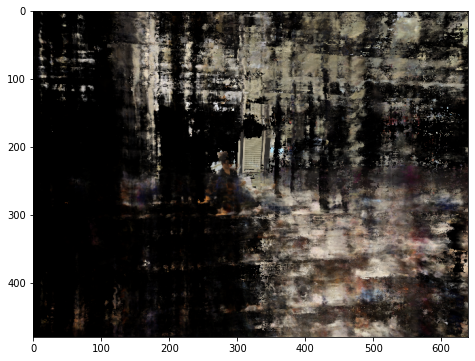

In [7]:
# genearte
time = .1  # in [0,1]
azimuth = 10  # in [-180,180]      # theta
elevation = 0  # in [-180,180]
img = generate_img(time, azimuth, elevation)

# display
plt.figure(2, figsize=(20,6))
plt.imshow(img)
plt.show()